In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from diffusion import ConditionalDiffusion

In [4]:
from modules import UNet_conditional, EMA
from torch.utils.tensorboard import SummaryWriter
from utils import setup_logging, save_images

In [5]:
import datetime
import numpy as np

In [6]:
import torchvision
from torchvision import transforms
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch import optim
from tqdm import tqdm
import logging
from PIL import Image

In [7]:
torch.cuda.device_count()

2

In [8]:
# test_labels=torch.arange(10).long()
# test_label_embedding = nn.Embedding(10, 256)
# labels_output=test_label_embedding(test_labels)
# test_labels

In [9]:
dt=datetime.datetime.now()

DATASET_PATH="../images_1_128"
NLABELS=4 # num metrics
NOISE_STEPS=500
CHANNELS=1
LU_VALS=[65, 130, 195, 255] # road, resi, retail, comm

### Test metrics

In [10]:
test_metrics = torch.FloatTensor(
    [[0.7, 0.1, 0.1, 0.1],
     [0.7, 0.1, 0.1, 0.1],
     [0.1, 0.7, 0.1, 0.1],
     [0.1, 0.7, 0.1, 0.1],
     [0.1, 0.1, 0.7, 0.1],
     [0.1, 0.1, 0.7, 0.1],
     [0.1, 0.1, 0.1, 0.7],
     [0.1, 0.1, 0.1, 0.7],
     [0.25, 0.25, 0.25, 0.25],
     [0.25, 0.25, 0.25, 0.25]])

In [11]:
# test_metric_embedding = nn.Linear(4, 256, bias=False)
# metrics_output=test_metric_embedding(test_metrics)

In [12]:
class ArgNamespace():
    def __init__(self):
        self.epochs = 500
        self.batch_size = 8
        self.lr = 3e-4
        self.image_size = 128
        self.dataset_path = DATASET_PATH
        self.channels = CHANNELS
        self.device = "cuda"
        self.image_save_interval=10
        self.model_save_interval=20
        self.noise_steps=NOISE_STEPS
        self.run_name = 'cond_{}{}{}{}_{}_{}'.format(
            dt.year, str(dt.month).zfill(2), str(dt.day).zfill(2), 
            str(dt.hour).zfill(2), CHANNELS, NOISE_STEPS)
        
args=ArgNamespace()

Create folders for model and results

In [13]:
setup_logging(args.run_name)

In [14]:
device = args.device

# Create the DataLoader

### Create the Dataset

In [15]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, img_dir):
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomHorizontalFlip(),
                transforms.Lambda(lambda t: (t /(255/2)) - 1), # norm from [0, 255] to [-1, -1]
            ])     
        self.image_files=[f for f in os.listdir(img_dir) if 'png' in f]
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)
    
    def get_metrics(self, image):
        metrics=[]
        for v in LU_VALS:
            score=((image - v).abs()<0.01).sum()/torch.numel(image)
            metrics.append(score)
        metrics_tensor=torch.FloatTensor(metrics)
        return metrics_tensor  

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = read_image(img_path)
        label = self.get_metrics(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [16]:
dataset = CustomImageDataset(args.dataset_path)

### Explore Data

Shape of image

In [17]:
dataset[0][0].shape

torch.Size([1, 128, 128])

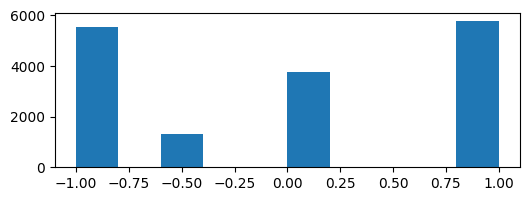

In [18]:
plt.figure(figsize=(6, 2))
_=plt.hist(dataset[0][0].numpy().flatten())

To plot in matplotlib, need to move the channel dimension to last
Also, since the images are already trnsformed to [-1,1], we convert back to [0,1]

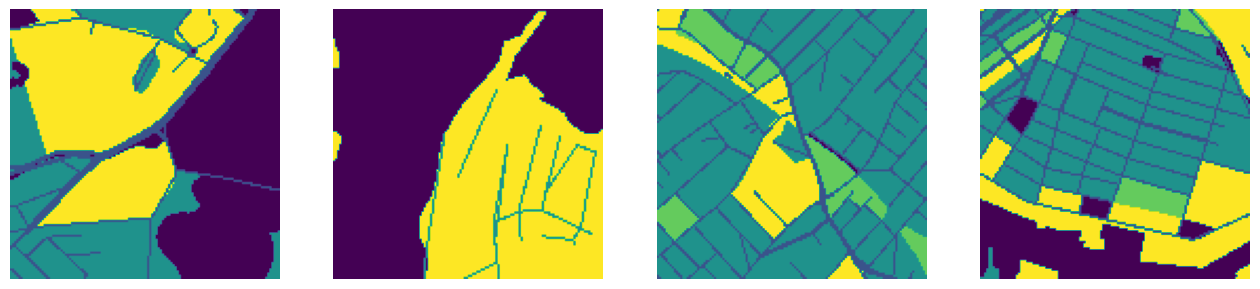

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axs[i].imshow(((dataset[i][0]+1)/2).permute(1, 2, 0))
    axs[i].set_axis_off()
fig.show()

View label

In [20]:
dataset[0][1]

tensor([0.0796, 0.2303, 0.0000, 0.3531])

### Create the DataLoader

In [21]:
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

# Create the Model

In [22]:
# def save_images(images, path, **kwargs):
#     grid = torchvision.utils.make_grid(images, **kwargs)
#     ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
#     im = Image.fromarray(ndarr)
#     im.save(path)

In [23]:
# Wrap the Model in DataParallel to use multiple GPUs
model = nn.DataParallel(
    UNet_conditional(
        image_size=128,c_in=args.channels, c_out=args.channels, time_dim=256,
        num_classes=4)
    ).to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
mse = nn.MSELoss()
diffusion = ConditionalDiffusion(noise_steps=args.noise_steps, img_size=args.image_size, device=device)
logger = SummaryWriter(os.path.join("runs", args.run_name))
l = len(dataloader)

In [24]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

23332481


In [25]:
for epoch in range(args.epochs):
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(dataloader)
    for i, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        if np.random.random() < 0.1:
            labels = None       
        predicted_noise = model(x_t, t, labels)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(MSE=loss.item())
        logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

    if epoch%args.image_save_interval==0:
        labels=test_metrics
        sampled_images = diffusion.sample(model, n=test_metrics.shape[0], 
                                          labels=labels, channels=args.channels)
        save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.png"))
    if epoch%args.model_save_interval==0:
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))

08:34:05 - INFO: Starting epoch 0:
  5%|███████                                                                                                                         | 21/384 [00:12<03:37,  1.67it/s, MSE=0.119]


KeyboardInterrupt: 